# Summary

# Imports

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import tqdm

from kmtools import db_tools

Reading __init__.py


In [2]:
%matplotlib inline

In [3]:
pd.set_option("max_columns", 100)

In [4]:
%run spark.ipynb

# Parameters

In [5]:
NOTEBOOK_PATH = Path('adjacency_matrix_subset_sample')
NOTEBOOK_PATH

PosixPath('adjacency_matrix_subset_sample')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab2/database_data/datapkg/hhsuite-wstructure/notebooks/adjacency_matrix_subset_sample')

# `DATAPKG`

In [7]:
DATAPKG = {}

In [8]:
DATAPKG['adjacency_matrix_subset'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("hhsuite-wstructure", "master", "adjacency_matrix_subset", "adjacency_matrix_subset.parquet")
)

# Explore

## Check the number of domains (`number_of_domains_df`)

In [9]:
query = f"""\
SELECT database_id, count(1) AS number_of_domains
FROM parquet.`{DATAPKG['adjacency_matrix_subset']}`
GROUP BY database_id
"""
db_tools.print_sql(query)

In [10]:
ds = spark.sql(query)

In [11]:
number_of_domains_df = ds.toPandas().sort_values("number_of_domains", ascending=False)

database_id  number_of_domains
339     G3DSA:2.60.40.10              18953
1344  G3DSA:3.40.50.1820               8819
1127    G3DSA:1.10.10.10               6315
106     G3DSA:1.25.40.10               5530
711     G3DSA:3.20.20.70               5342

database_id  number_of_domains
1268   G3DSA:1.20.1400.10                  1
522    G3DSA:3.30.1750.10                  1
547   G3DSA:3.30.1490.170                  1
1265    G3DSA:2.60.370.10                  1
1353   G3DSA:1.10.287.760                  1

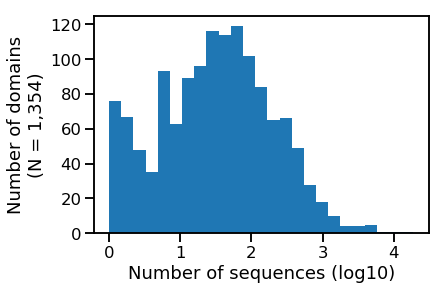

In [12]:
display(number_of_domains_df.head())

display(number_of_domains_df.tail())

with sns.plotting_context("talk"):
    _ = plt.hist(np.log10(number_of_domains_df['number_of_domains']), bins=25)
    plt.xlabel("Number of sequences (log10)")
    plt.ylabel(f"Number of domains\n(N = {len(set(number_of_domains_df['database_id'])):,})")

## Check domain lengths (`domain_lengths_df`)

In [13]:
query = f"""\
SELECT alignment_length
FROM parquet.`{DATAPKG['adjacency_matrix_subset']}`
"""
db_tools.print_sql(query)

In [14]:
ds = spark.sql(query)

In [15]:
domain_lengths_df = ds.toPandas().sort_values("alignment_length", ascending=False)

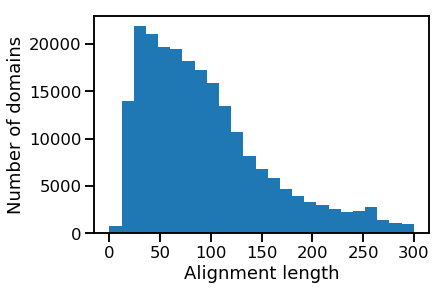

In [16]:
with sns.plotting_context("talk"):
    _ = plt.hist(domain_lengths_df['alignment_length'], bins=25, range=(0, 300))
    plt.xlabel("Alignment length")
    plt.ylabel(f"Number of domains")

# Create subset

In [17]:
query_template = """\
SELECT *
FROM parquet.`{path}`
WHERE alignment_length > 60 AND alignment_length <= 200
ORDER BY RAND(42)
"""

## Make sure it works

In [18]:
ds = (
    spark.sql(query_template.format(path=DATAPKG['adjacency_matrix_subset']))
    .dropDuplicates(['structure_id'])
    .limit(10)
)

In [19]:
df = ds.toPandas()

In [20]:
display(df.head(1))
print(len(df))

__index_level_0__     uniparc_id  \
0          871269249  UPI0001752786   

                                            sequence database  \
0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   Gene3D   

              interpro_name interpro_id  domain_start  domain_end  \
0  Immunoglobulin-like fold   IPR013783           180         256   

   domain_length structure_id  model_id chain_id  pc_identity  \
0             77         1A02       0.0        C        100.0   

   alignment_length  mismatches  gap_opens  q_start  q_end  s_start  s_end  \
0              77.0         0.0        0.0      1.0   77.0    180.0  256.0   

   evalue_log10  bitscore                                               qseq  \
0    -50.221849     164.0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   

                                                sseq  \
0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   

                                                 a2b  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                                 b2a  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                       residue_idx_1  \
0  [179.0, 179.0, 179.0, 179.0, 179.0, 180.0, 180...   

                                       residue_idx_2  \
0  [180.0, 181.0, 202.0, 203.0, 204.0, 179.0, 181...   

                                        residue_id_1  \
0  [201.0, 201.0, 201.0, 201.0, 201.0, 202.0, 202...   

                                        residue_id_2  \
0  [202.0, 203.0, 224.0, 225.0, 226.0, 201.0, 203...   

                                        residue_aa_1  \
0  [P, P, P, P, P, M, M, M, M, M, M, M, M, V, V, ...   

                                        residue_aa_2  \
0  [M, V, Q, N, F, P, V, E, T, G, Q, N, F, P, M, ...   

                             residue_idx_1_corrected  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...   

                             residue_idx_2_corrected       database_id  
0  [1.0, 2.0, 23.0, 24.0, 25.0, 0.0, 2.0, 3.0, 21...  G3DSA:2.60.40.10

10


## Production

In [21]:
assert len(number_of_domains_df) == len(number_of_domains_df['database_id'].drop_duplicates())

In [22]:
dfs = []

for database_id in tqdm.tqdm_notebook(
        number_of_domains_df['database_id'].values,
        total=len(number_of_domains_df)
):
    path = (
        DATAPKG['adjacency_matrix_subset']
        .joinpath(f"database_id={database_id}".replace(':', '%3A'))
        .as_posix()
    )
    ds = (
        spark.sql(query_template.format(path=path))
        .dropDuplicates(['structure_id'])
        .limit(10)
    )
    df = ds.toPandas()
    dfs.append(df)

HBox(children=(IntProgress(value=0, max=1354), HTML(value='')))

In [23]:
adjacency_matrix_subset_sample = pd.concat(dfs, ignore_index=True)

In [24]:
adjacency_matrix_subset_sample_file = (
    OUTPUT_PATH.joinpath("adjacency_matrix_subset_sample.parquet")
)
adjacency_matrix_subset_sample_file

PosixPath('/home/kimlab2/database_data/datapkg/hhsuite-wstructure/notebooks/adjacency_matrix_subset_sample/adjacency_matrix_subset_sample.parquet')

In [25]:
out = (
    spark
    .createDataFrame(adjacency_matrix_subset_sample)
    .coalesce(1)
    .write
    .parquet(
        adjacency_matrix_subset_sample_file.as_posix(),
        mode="overwrite",
        compression="snappy")
)

In [26]:
print(len(adjacency_matrix_subset_sample))
# 9298 (without filtering for unique pdbs)
# 7134 (with filtering for unique pdbs)

7134


# Validate

In [27]:
adjacency_matrix_subset_sample_out = (
    spark
    .read
    .parquet(adjacency_matrix_subset_sample_file.as_posix())
    .toPandas()
)

In [28]:
adjacency_matrix_subset_sample.equals(adjacency_matrix_subset_sample_out)

False

In [29]:
assert (adjacency_matrix_subset_sample.columns == adjacency_matrix_subset_sample_out.columns).all()

In [30]:
assert (adjacency_matrix_subset_sample.index == adjacency_matrix_subset_sample_out.index).all()

In [31]:
for c in adjacency_matrix_subset_sample.columns:
    try:
        assert (adjacency_matrix_subset_sample[c] == adjacency_matrix_subset_sample_out[c]).all()
    except ValueError:
        # It gets tricky when columns are lists...
        for a, b in zip(adjacency_matrix_subset_sample[c], adjacency_matrix_subset_sample_out[c]):
            assert (a == b).all()